# Loading packages 

In [104]:
import pandas as pd
import inflection
import math
import numpy as np
import datetime
import scipy
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt 



from matplotlib import gridspec 
from IPython.core.display import HTML 
from IPython.display import Image

from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb

# Loading Data

In [105]:
df_sales_raw = pd.read_csv('train.csv', low_memory = False)
df_store_raw = pd.read_csv('store.csv', low_memory = False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on ='Store')

In [106]:
df_raw.shape

(1017209, 18)

In [107]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data Description 

In [108]:
df1 = df_raw.copy()

### Renaming columns

In [109]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [110]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

### Data Dimensions

In [111]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### Data types

In [112]:
df1['date']= pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### Checking NA's

In [113]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Fillout NA's

In [114]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
31468,249,5,2015-07-03,6356,588,1,1,0,0,d,c,18010.0,9.0,2014.0,0,NaN,NaN,NaN


In [115]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month']= df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis =1)

#competition_open_since_year     
df1['competition_open_since_year']= df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis =1)                       

#promo2_since_week               
df1['promo2_since_week']= df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis =1)                       

#promo2_since_year               
df1['promo2_since_year']= df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis =1)                       

#promo_interval                  
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec',}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo']= df1[['promo_interval', 'month_map']].apply(lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 )




In [116]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change types

In [117]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [118]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week']=df1['promo2_since_week'].astype(int)
df1['promo2_since_year']=df1['promo2_since_year'].astype(int)

### Descriptive Statistics 

In [119]:
num_attributes = df1.select_dtypes(include = ['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','int32', 'float64','datetime64[ns]'])

In [120]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
213435,471,3,5819,506,1,0,0,5300.0,1,2015,1,45,2009,0
8320,516,5,5133,593,1,0,1,20.0,7,2015,1,35,2010,0


#### Numerical Attributes

In [121]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min )).T
d3 = pd.DataFrame(num_attributes.apply(max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate 
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

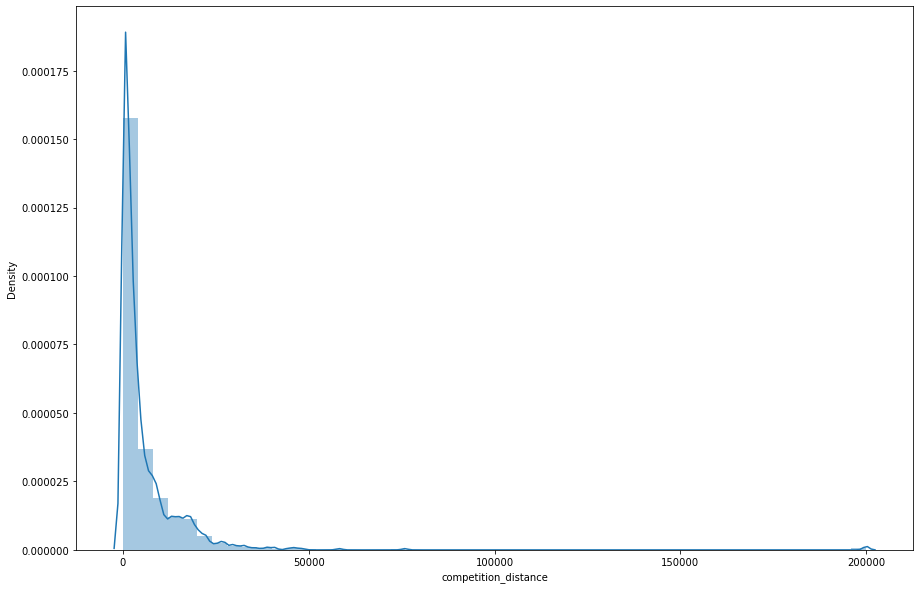

In [122]:
sns.distplot(df1['competition_distance'])

### Categorial Atrributes

In [123]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

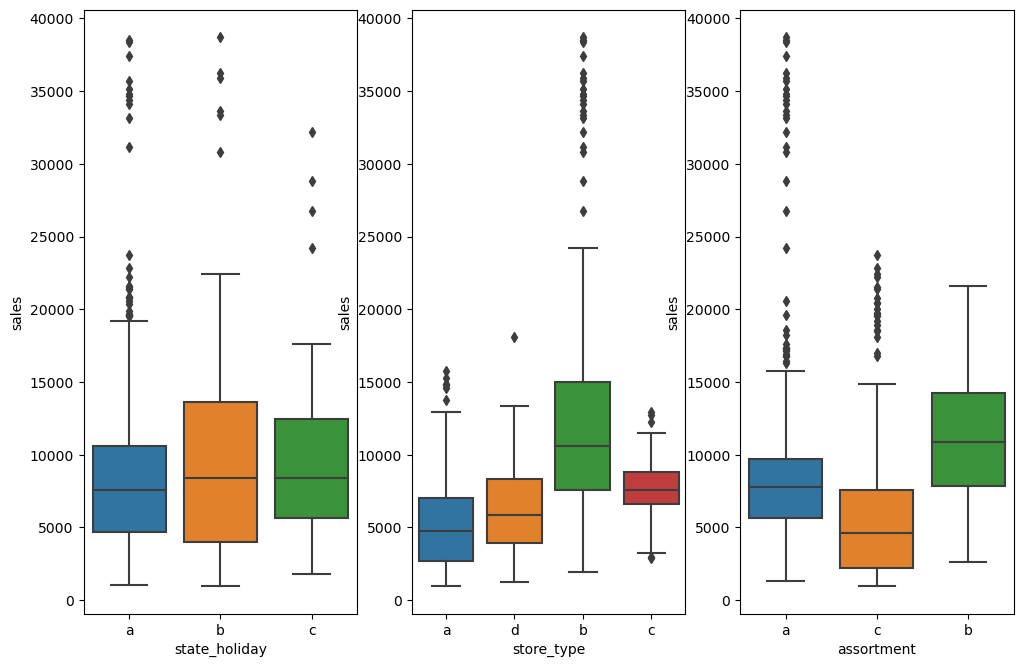

In [124]:
aux_1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)] 

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales',  data = aux_1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales',  data = aux_1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales',  data = aux_1)


#  Feature engineering 

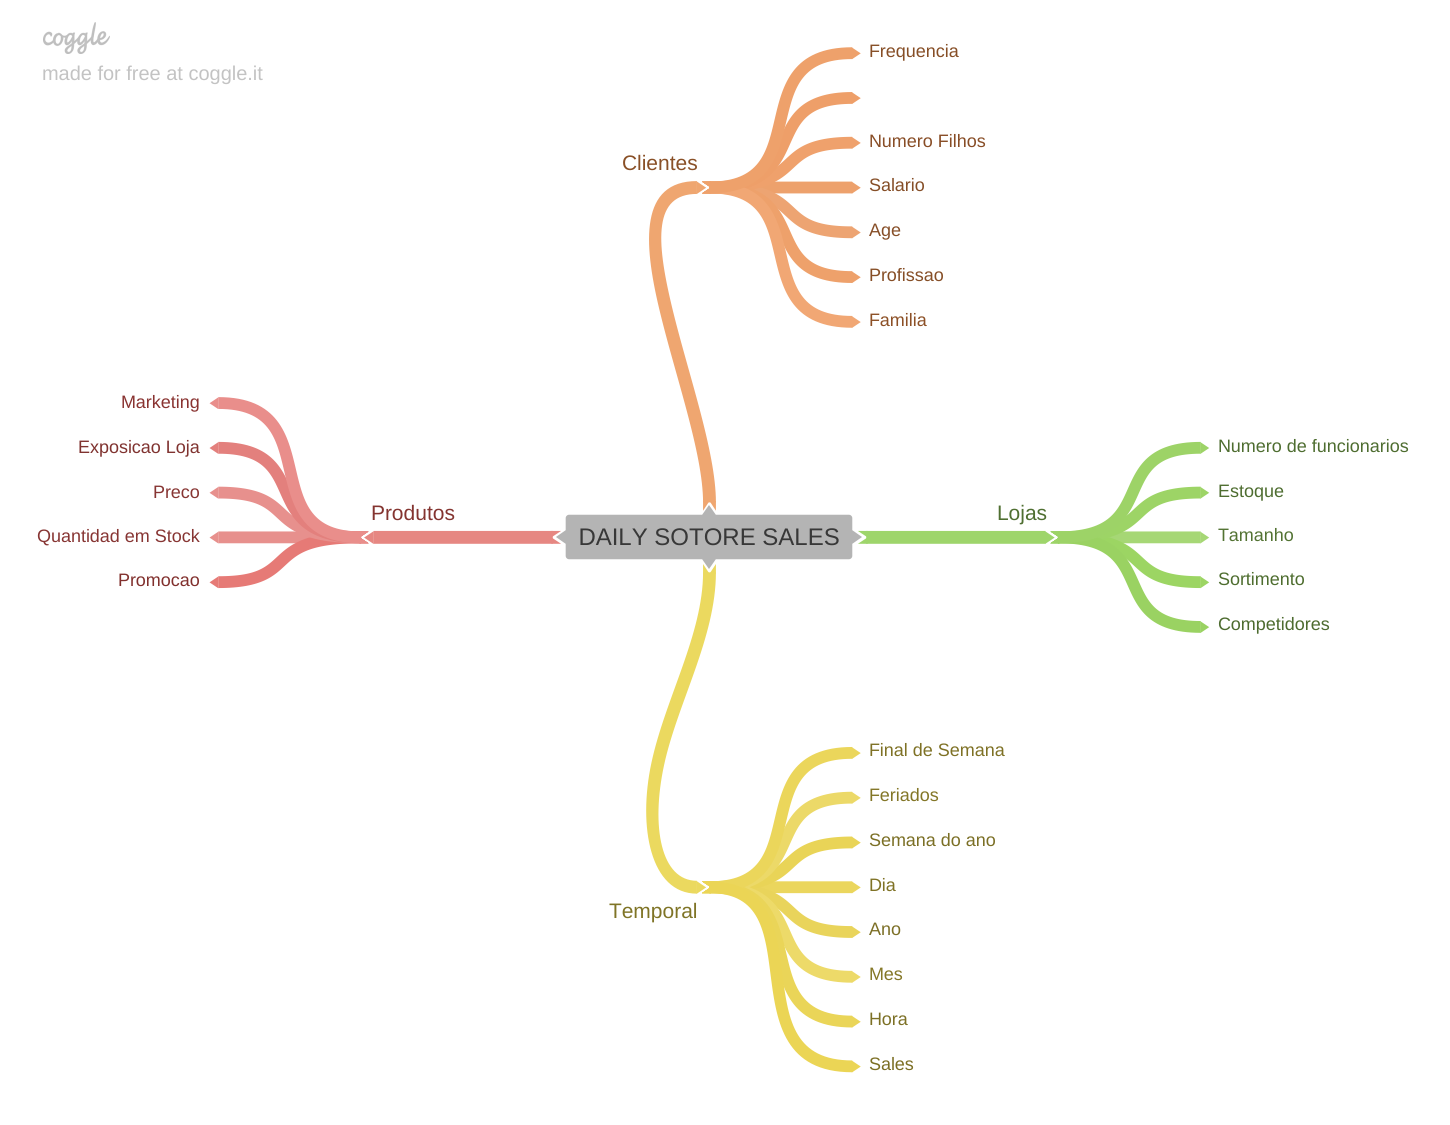

In [125]:
Image('img/DAILY_SOTORE_SALES.png')

## Hypothesis creation

### Store hypothesis

**1.** Higher number of employees should lead to higher selling volume

**2.** Higher stocked stores should lead to higher selling volume

**3.** Bigger stores should lead to higher selling volume

**4.** Better assortment in stores should lead to higher selling volume

**5.** Stores having competitors nearby should have less selling volume

**6.** Stores having lasting competitors nearby should have less selling volume

### Product hypothesis

**1.** Stores investing more in marketing should lead to higher selling volume

**2.** The more products being exposed in showcase should lead to higher selling volume

**3.** Stores displaying less priced product should lead to higher selling volume

**4.** Stores displaying less priced product longer should lead to higher selling volume

**5.** The more aggressive a promo is, the higher the selling volume

**6.** Stores displaying longer promos should have a higher selling volume 

**7.** More days with an active promo should lead to higher selling volume 

**8.** Stores displaying more consecutive promos should have higher selling volume

### Time hypothesis

**1.** Stores having more holidays should lead to lesser selling volume

**2.** Stores should have higher sellings through years

**3.** Stores should have higher selling volume on second semester each year

**4.** Stores should have higher selling volume after day 10 of month

**5.** Stores should have lesser selling volume on weekends

**6.** Stores shoudl have lesser selling volume on school holidays

## Final list of hypothesis. 

**1.** Better assortment in stores should lead to higher selling volume

**2.** Stores having competitors nearby should have less selling volume

**3.** Stores having lasting competitors nearby should have less selling volume

**4.** Stores displaying longer promos should have a higher selling volume 

**5.** More days with an active promo should lead to higher selling volume 

**6.** Stores displaying more consecutive promos should have higher selling volume

**7.** Stores having more holidays should lead to lesser selling volume

**8.** Stores should have higher sellings through years

**9.** Stores should have higher selling volume on second semester each year

**10.** Stores should have higher selling volume after day 10 of month

**11.** Stores should have lesser selling volume on weekends

**12.** Stores shoudl have lesser selling volume on school holidays

## Feature engineering

In [126]:
# year
df1['year'] = df1['date'].dt.year
# month
df1['month'] = df1['date'].dt.month
# day
df1['day'] = df1['date'].dt.day
# week of the year
df1['week_of_year'] = df1['date'].dt.weekofyear
# year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

# competition since 
df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df1['competition_time_month'] = ((df1['date']-df1['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days= 7))
df1['promo_time_week'] = ((df1['date']-df1['promo_since'])/7).apply(lambda x: x.days).astype(int)
# assortment
df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended')
# state holiday
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'eastern_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

In [127]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [128]:
df1['assortment']

0             basic
1             basic
2             basic
3          extended
4             basic
             ...   
1017204       basic
1017205    extended
1017206    extended
1017207    extended
1017208    extended
Name: assortment, Length: 1017209, dtype: object

# Data Filtering 

In [129]:
df3 = df1.copy()

In [130]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Row filtering

In [131]:
df3['open']

0          1
1          1
2          1
3          1
4          1
          ..
1017204    0
1017205    0
1017206    0
1017207    0
1017208    0
Name: open, Length: 1017209, dtype: int64

In [132]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Column Selection

In [133]:
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [134]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# Exploratory Data Analysis (EDA)

In [135]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

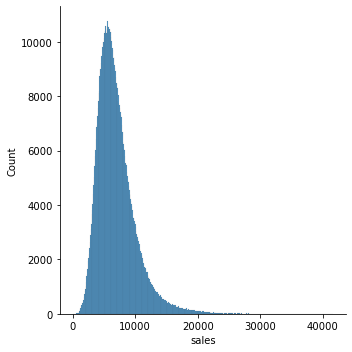

In [136]:
sns.displot(df4['sales'])

### Numerical Variable

In [137]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

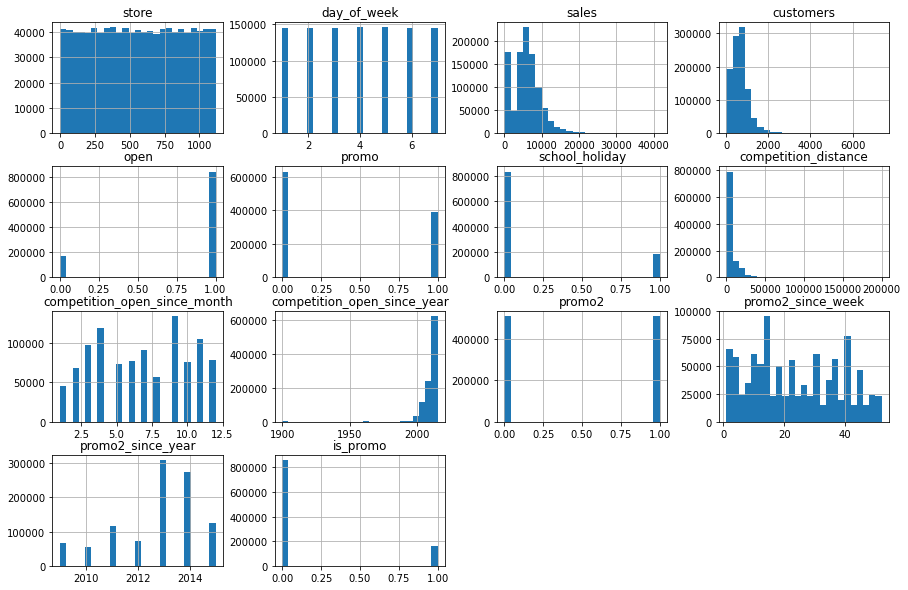

In [138]:
num_attributes.hist(bins =25);

### Categorical Variable

In [139]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [140]:
set(df4['assortment'].tolist())

{'basic', 'extended', 'extra'}

<AxesSubplot:xlabel='sales', ylabel='Density'>

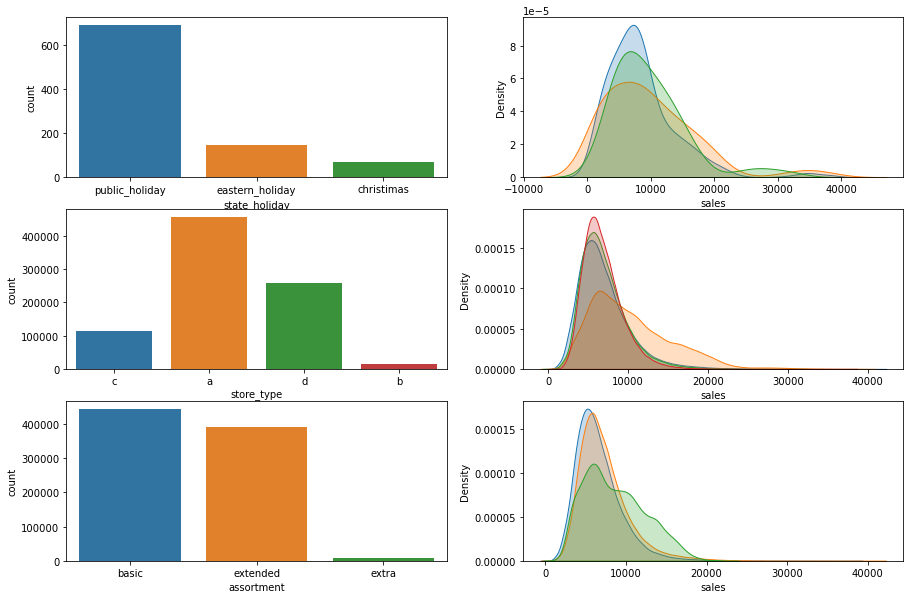

In [141]:
## State holiday
plt.subplot(3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade =True)
sns.kdeplot(df4[df4['state_holiday'] == 'eastern_holiday']['sales'], label = 'eastern_holiday', shade =True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label = 'christimas', shade =True)

# store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade =True)

#Assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade =True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade =True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade =True)


## Bivariate Analysis

### **H1.** Higher assortment should lead to higher selling volume
**FALSE** Most assorted stores sell less

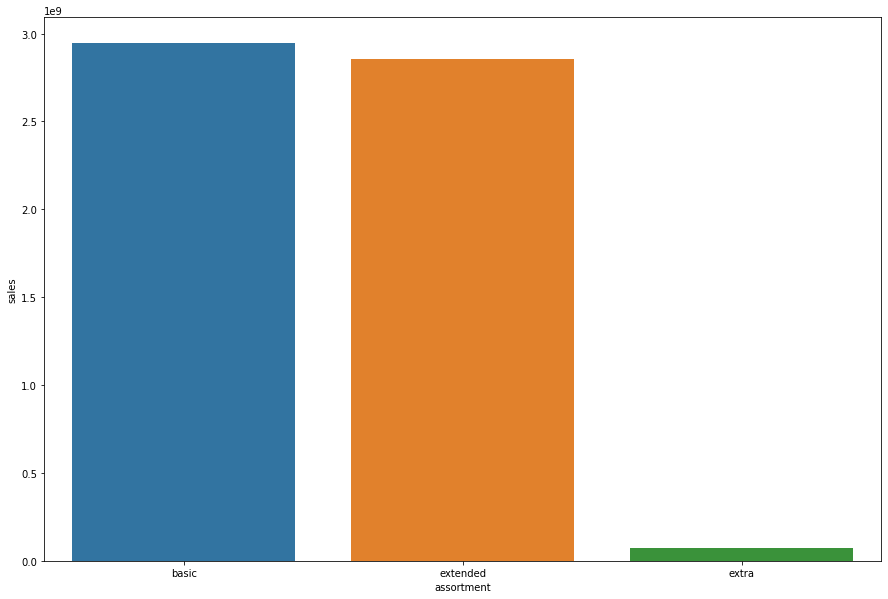

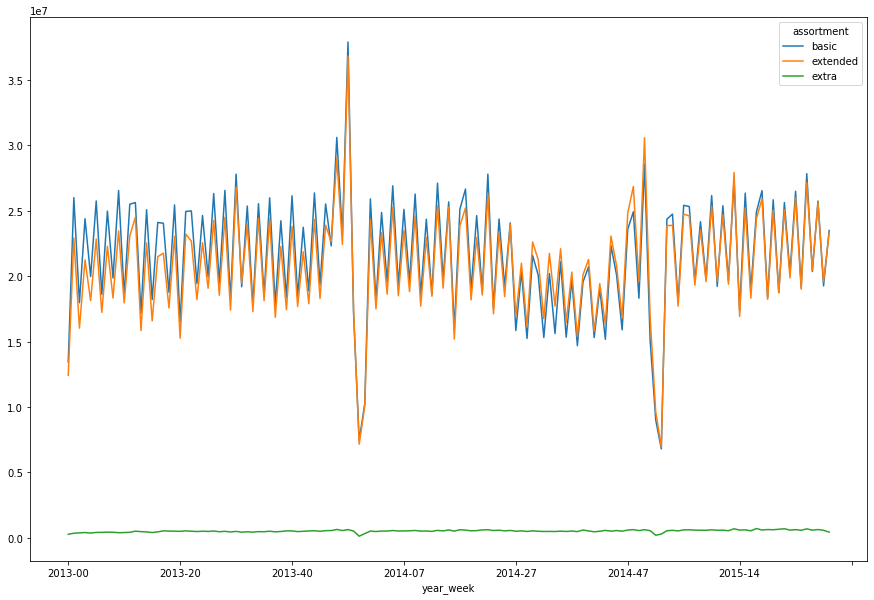

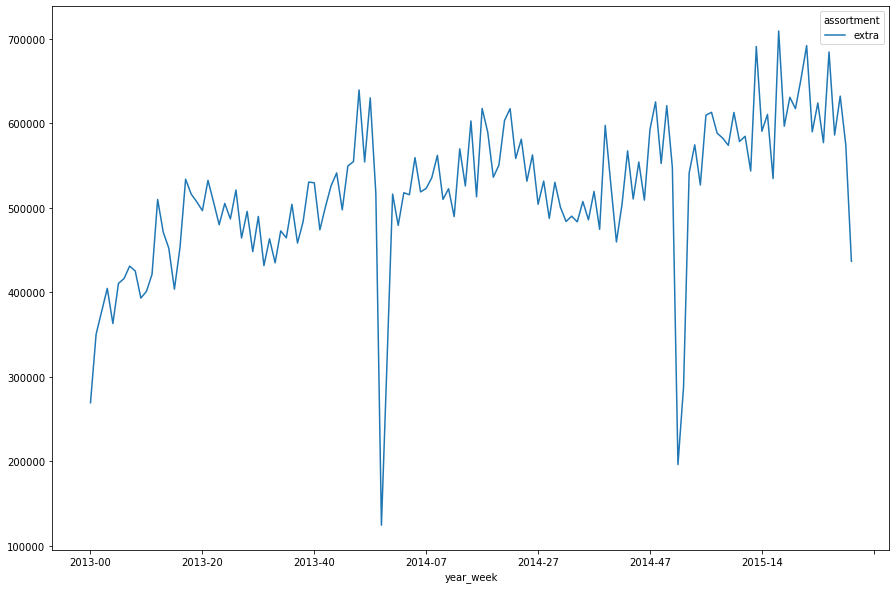

In [142]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns= 'assortment', values ='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns= 'assortment', values ='sales').plot();


In [143]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### **H2.** Stores having competence stores nearby should have lesser selling volume
**FALSE**, stores having competence stores nearby have higher selling volume


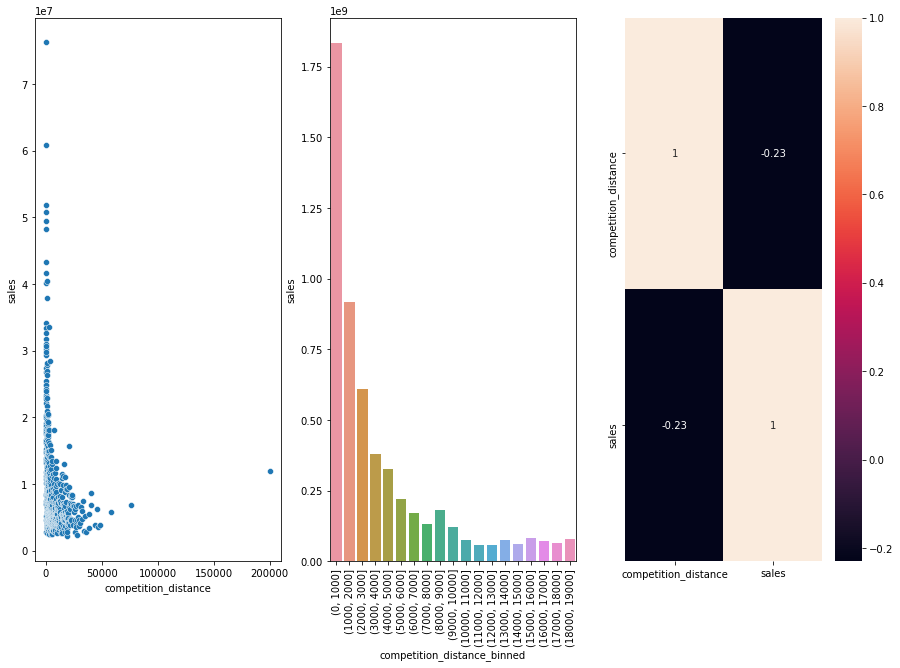

In [144]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = aux1['competition_distance'], y='sales', data = aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales', data= aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H3.**  Stores with lasting competition sell more
**FALSE** stores with lasting competition sell less

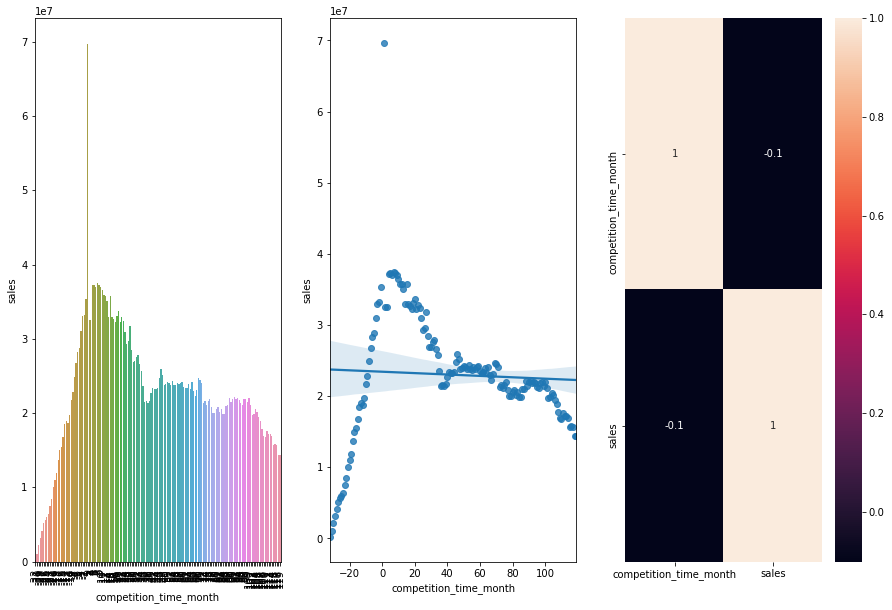

In [145]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month', y='sales', data = aux2)
plt.xticks(rotation =90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method ='pearson'), annot=True);

### **H4.**  Longer active promos should lead to higher sellings
**FALSE** stores with lasting promos are selling less, after a certain promo period

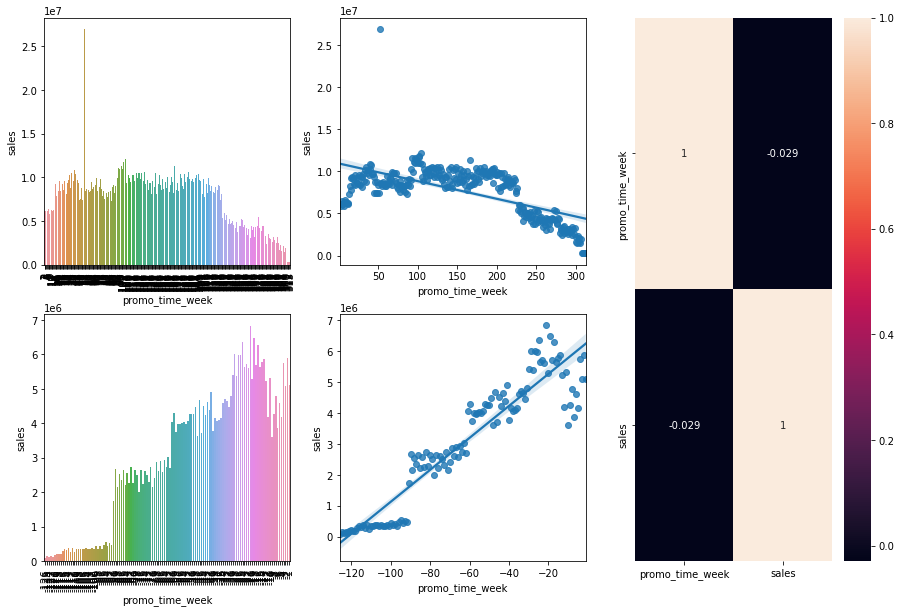

In [146]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # extended promo
sns.barplot(x='promo_time_week',y='sales', data= aux2)
plt.xticks(rotation =90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales', data= aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # promo regular
sns.barplot(x='promo_time_week',y='sales', data= aux3)
plt.xticks(rotation =90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales', data= aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H5.** Stores with more days with promos  should display higher sellings

### **H7.** Stores with more consecutive promos should display higher sellings
**FALSE** Stores displaying more consecutive promos are actually selling less

In [147]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


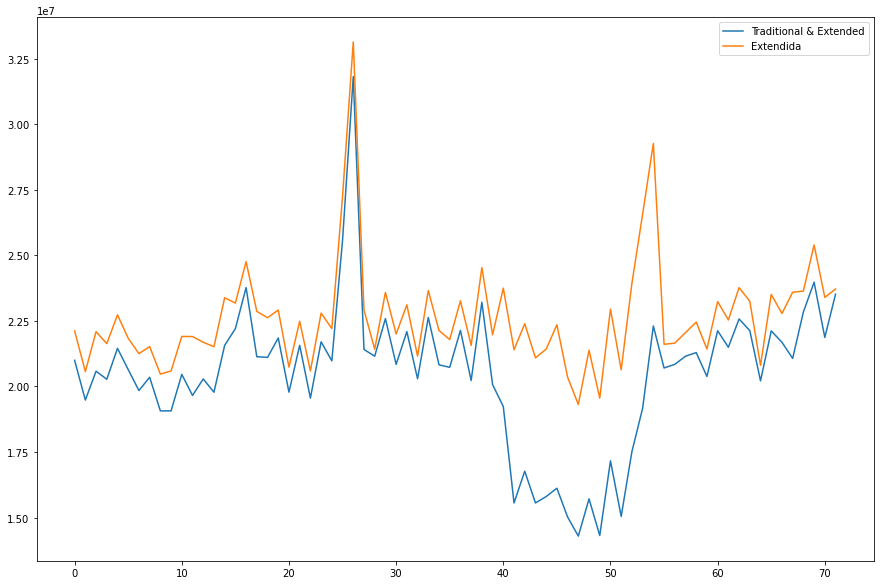

In [148]:
aux1 = df4[(df4['promo'] == 1)&(df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1)&(df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Traditional & Extended','Extendida']);


### **H7**. Stores being opened on crhistmas should display higher selling volume
**FALSE**. No higher selling volume is displayed on crhistmas

<AxesSubplot:xlabel='year', ylabel='sales'>

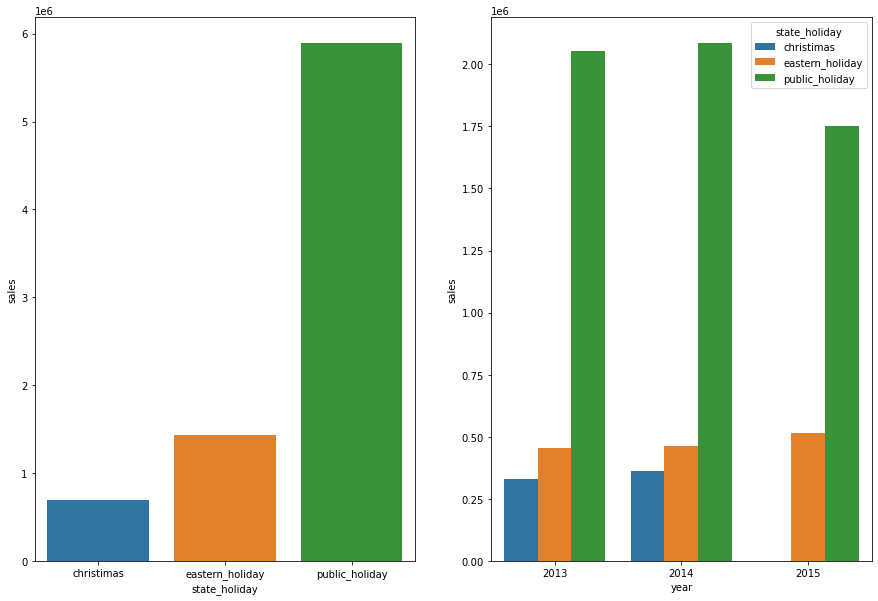

In [149]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue= 'state_holiday', data=aux2)

### **H8**. Stores should have higher sellings through years


<AxesSubplot:>

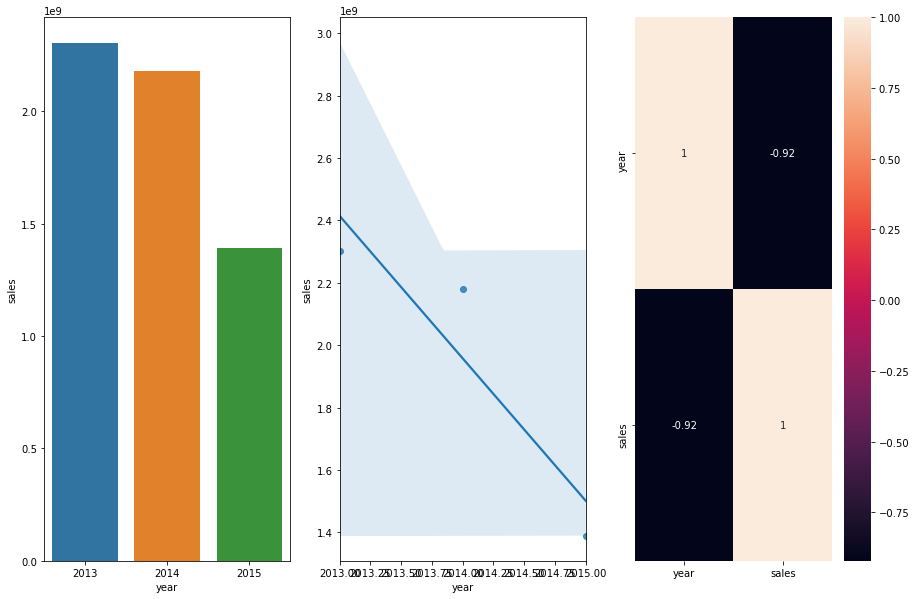

In [150]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data =aux1)
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data =aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H9**. Stores should have higher selling volume on second semester each year
**FALSE**. Stores display higher selling volume on first semester


<AxesSubplot:>

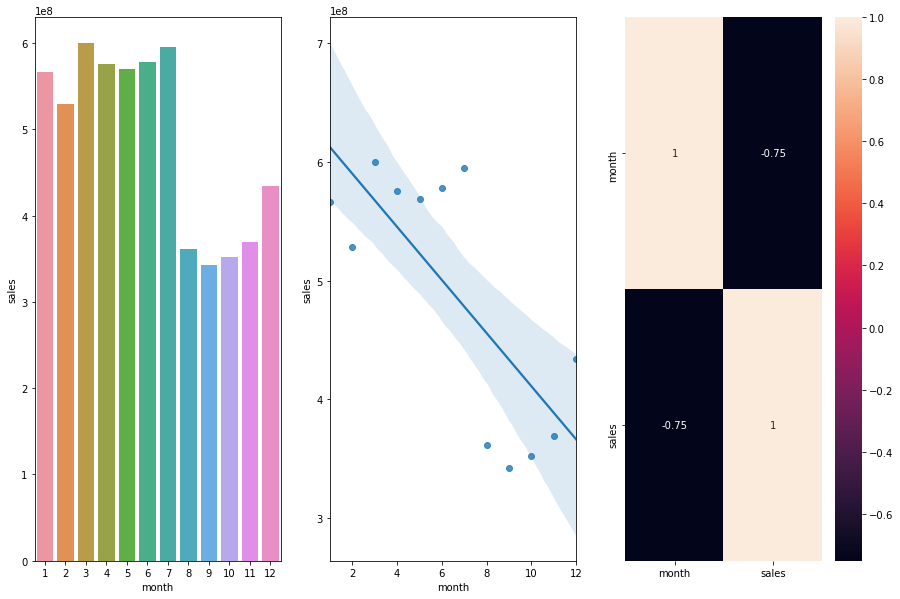

In [151]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data =aux1)
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data =aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H10**. Stores should have higher selling volume after day 10 of month
**TRUE**. Stores display higher selling volume after day 10

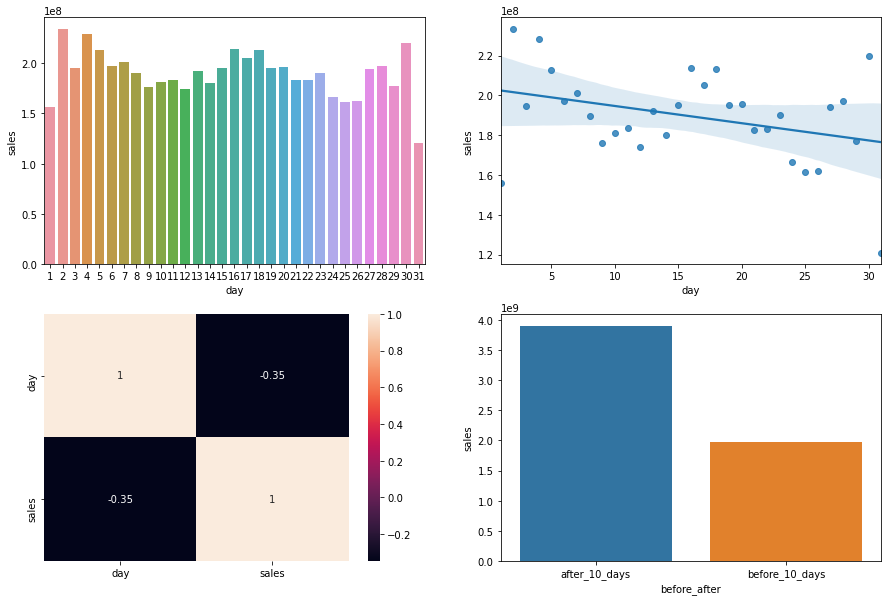

In [152]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data =aux1)
plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data =aux1)
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.subplot(2,2,4)

aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data = aux2);

### **H11**. Stores should have lesser selling volume on weekends
**TRUE**. Stores display lesser selling volume on weekends


<AxesSubplot:>

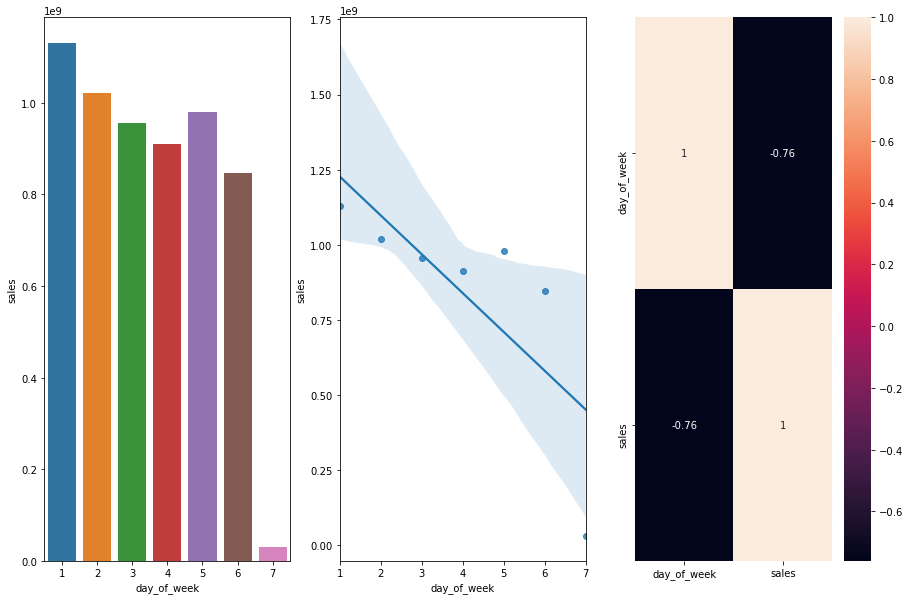

In [153]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data =aux1)
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data =aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H12**. Stores should have lesser selling volume on school holidays
**TRUE**. Stores display lesser selling volume on school holiday, except July and August. 

<AxesSubplot:xlabel='month', ylabel='sales'>

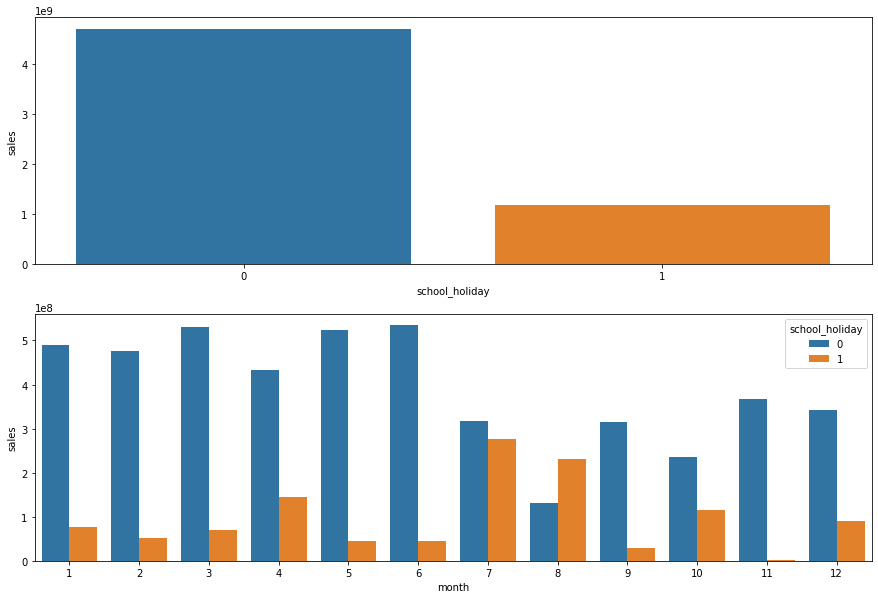

In [154]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']]. groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data= aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']]. groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data= aux2)

## Multivariate Analysis

### Numerical Attributes

<AxesSubplot:>

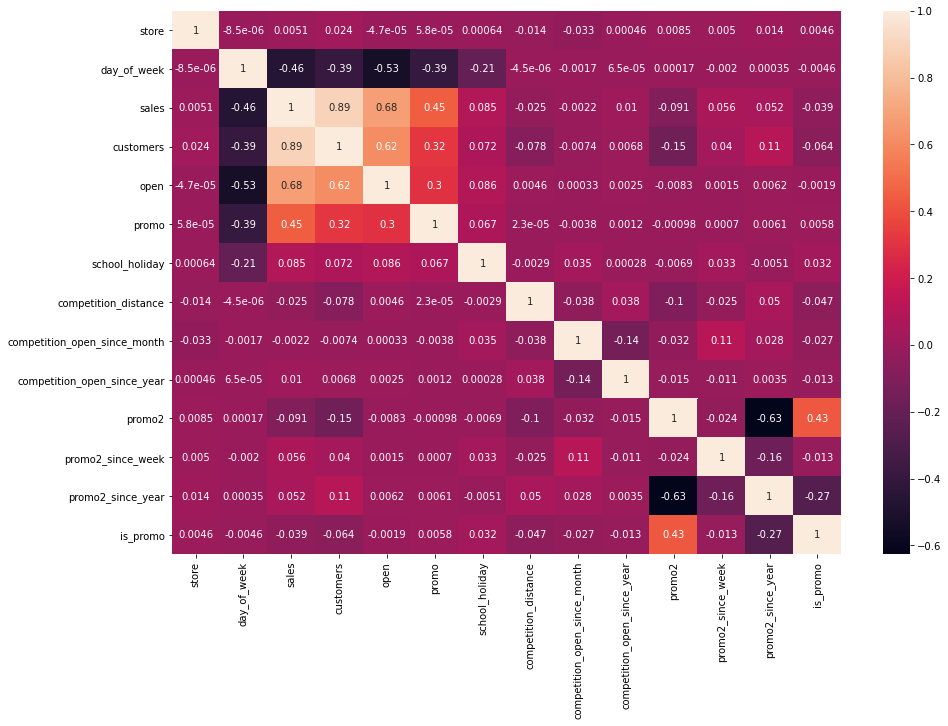

In [155]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot =True)

### Categorical Attributes

In [156]:
def cramer_v(x,y): 
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(rcorr-1,kcorr-1)))

<AxesSubplot:>

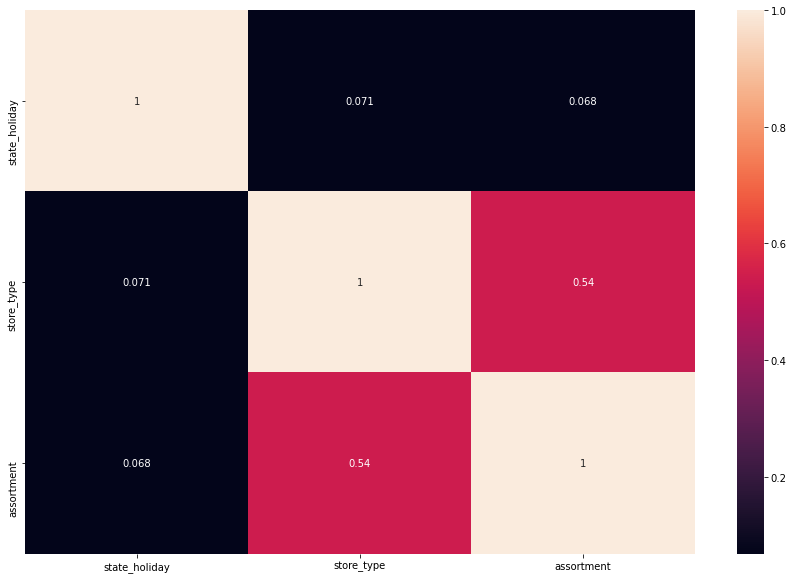

In [157]:
# only categoricaldata
a  = df4.select_dtypes(include ='object')


# Compute Cramer V 
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

# Final data frame
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})
d = d.set_index(d.columns)

sns.heatmap(d, annot= True)

# Data Preparation 

In [158]:
df5 = df4.copy()
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


##   Data Normalization

## Data Rescaling

In [233]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs,open('parameter/competition_distance_scaler.pkl','wb'))
# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms,open('parameter/year_scaler.pkl','wb'))
# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs,open('parameter/competition_time_month_scaler.pkl','wb'))
# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs,open('parameter/promo_time_week_scaler.pkl','wb'))

## Data Transformation

### Encoding

In [236]:
# state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix = 'state_holiday', columns = ['state_holiday'])

KeyError: "None of [Index(['state_holiday'], dtype='object')] are in the [columns]"

In [235]:
# store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump(le,open('parameter/store_type_scaler.pkl','wb'))

In [162]:
# assortment - ordinal encoding 
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### Response Variable Transformation 

In [163]:
df5['sales'] = np.log1p(df5['sales'])

In [164]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x*2.*np.pi/7))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x*2.*np.pi/7))

# month
df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x*2.*np.pi/12))
df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x*2.*np.pi/12))

# day
df5['day_sin'] = df5['day'].apply(lambda x : np.sin(x*2.*np.pi/30))
df5['day_cos'] = df5['day'].apply(lambda x : np.cos(x*2.*np.pi/30))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x*2.*np.pi/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x*2.*np.pi/52))

In [165]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# Feature Selection


In [166]:
df6 = df5.copy()

In [167]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## Split dataframe into training and test dataset

In [168]:
cols_drop = ['week_of_year','day','month','day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [169]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0]- datetime.timedelta(days = 7*6)

Timestamp('2015-06-19 00:00:00')

In [170]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Testing dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('Testing Min Date: {}'.format(X_test['date'].min()))
print('Testing Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [ ]:
# training and testing dataset for Boruta
X_train_n = X_train.drop(['date','sales'], axis = 1).values
y_train_n = y_train.ravel()

# define random forest regressor 
rf = RandomForestRegressor(n_jobs = -1)

# define Boruta 
boruta = BorutaPy( rf, n_estimators = 'auto', verbose =2, random_state = 42).fit(X_train_n, y_train_n)

### Best features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date','sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# not selected Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [171]:
X_train.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christimas',
       'state_holiday_eastern_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

## Manual Feature Selection

In [172]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin', 
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# columns to add 
feat_to_add = ['sales','date']
# final features
cols_selected_boruta.extend(feat_to_add)


cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend(feat_to_add)

In [173]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'sales',
 'date']

# Machine Learning modelling 

In [ ]:
def mean_absolute_percentage_error(y,y_hat):
    return np.mean(np.abs((y-y_hat)/y))

def mean_percentage_error(y,y_hat):
    return np.mean((y-y_hat)/y)

def ml_error(model_name, y, y_hat): 
    mae = mean_absolute_error(y,y_hat)
    mape =  mean_absolute_percentage_error(y,y_hat)
    rmse = np.sqrt(mean_squared_error(y,y_hat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse},index=[0])

In [175]:
def cross_validation(x_training, kfold,model_name,model,verbose =False):
    mae_list =[]
    mape_list =[]
    rmse_list =[]
    for k in reversed(range(1,kfold+1)):
        if verbose :
            print('Kfold number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date','sales'],axis =1)
        ytraining = training['sales']
        #validation
        xvalidation = validation.drop(['date','sales'],axis =1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name':model_name,
                    'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                     'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                     'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index = [0])

In [176]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

In [177]:
x_train.columns

Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos',
       'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos',
       'week_of_year_sin', 'sales', 'date'],
      dtype='object')

## Average Model 

In [75]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store' )
yhat_baseline = aux1['predictions']

#performance

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## Linear Regression Model 

In [76]:
# model 
lr = LinearRegression()#.fit(x_train,y_train)
# # prediction
# yhat_lr = lr.predict(x_test)
# # performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
# lr_result

### Linear Regression Model - Cross Validation

In [77]:
lr_result_cv = cross_validation(x_training, 5,'Linear Regression', lr, verbose=False)

In [78]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## Linear Regression Regularized model - Lasso 

In [79]:
# model 
lrr = Lasso(alpha = 0.01)#.fit(x_train,y_train)
# # prediction
# yhat_lrr = lrr.predict(x_test)
# # performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
# lrr_result

### Lasso - Cross Validation

In [80]:
lrr_result_cv = cross_validation(x_training, 5,'Lasso', lrr, verbose=False)

In [81]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## Random Forest Regressor 

In [82]:
# model 
rf = RandomForestRegressor(n_estimators = 100, n_jobs =-1, random_state = 42)#.fit(x_train,y_train)
# # prediction
# yhat_rf = rf.predict(x_test)
# # performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

### Random Forest - Cross Validation

In [83]:
rf_result_cv = cross_validation(x_training, 5,'Random Forest Regressor', rf, verbose=True)

Kfold number: 5
Kfold number: 4
Kfold number: 3
Kfold number: 2
Kfold number: 1


In [84]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.57 +/- 218.7,0.12 +/- 0.02,1256.2 +/- 319.51


## XGBoost Regressor 

In [85]:
# model 
model_xgb= xgb.XGBRegressor(objective = 'reg:squarederror', 
                            n_estimators = 100,
                           eta = 0.01,
                           max_depth = 10, 
                           subsample = 0.7, 
                           colsample_bytee =0.9)#.fit(x_train,y_train)
# # prediction
# yhat_xgb = model_xgb.predict(x_test)
# # performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

### XGBoost Regressor - Cross Validation

In [86]:
xgb_result_cv = cross_validation(x_training, 5,'XGBoost Regressor', model_xgb, verbose=True)

Kfold number: 5
[08:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Kfold number: 4
[08:42:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Kfold number: 3
[08:44:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This

## Comparing models perfomance

### Real Performance - Cross Validation

In [87]:
modelling_result = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv, xgb_result_cv])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.57 +/- 218.7,0.12 +/- 0.02,1256.2 +/- 319.51
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7047.92 +/- 587.62,0.95 +/- 0.0,7713.99 +/- 688.69


# Hyperparameter Fine Tuning

## Random Search

In [88]:
import random
import warnings
warnings.filterwarnings('ignore')

In [89]:
param = {
         'n_estimators':[1500, 1700,2500, 3000, 3500],
         'eta':[0.01,0.03],
         'max_depth':[3,5,9],
         'subsample':[0.1,0.5,0.7],
         'colsample_bytee':[0.3,0.7,0.9],
         'min_child_weight':[3,8,15]
        }
MAX_EVAL = 10

In [90]:
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    # model 
    model_xgb= xgb.XGBRegressor(objective = 'reg:squarederror', 
                            n_estimators = hp['n_estimators'],
                           eta = hp['eta'],
                           max_depth = hp['max_depth'], 
                           subsample = hp['subsample'], 
                           colsample_bytee =hp['colsample_bytee'],
                           min_child_weight = hp['min_child_weight'])
    # performance
    result = cross_validation(x_training,5, 'XGBoost Regression', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

final_result
    

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 8}
[08:51:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:00:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.7,

[17:48:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regression,811.65 +/- 84.65,0.11 +/- 0.01,1178.47 +/- 150.15
0,XGBoost Regression,1269.21 +/- 38.88,0.17 +/- 0.0,1872.93 +/- 81.68
0,XGBoost Regression,931.58 +/- 69.88,0.12 +/- 0.01,1357.21 +/- 127.12
0,XGBoost Regression,1488.0 +/- 44.31,0.2 +/- 0.0,2170.0 +/- 81.25
0,XGBoost Regression,838.77 +/- 86.11,0.11 +/- 0.01,1219.04 +/- 152.73
0,XGBoost Regression,1667.48 +/- 50.48,0.22 +/- 0.0,2429.85 +/- 90.69
0,XGBoost Regression,1617.25 +/- 50.84,0.22 +/- 0.0,2358.19 +/- 90.89
0,XGBoost Regression,1193.24 +/- 40.26,0.16 +/- 0.0,1758.8 +/- 81.09
0,XGBoost Regression,1015.67 +/- 62.85,0.14 +/- 0.0,1474.54 +/- 115.13
0,XGBoost Regression,1013.54 +/- 54.22,0.14 +/- 0.0,1477.67 +/- 100.34


## Final Model

In [186]:
param_tuned = {
         'n_estimators': 3000,
         'eta':0.03,
         'max_depth':7,
         'subsample':0.7,
         'colsample_bytee':0.7,
         'min_child_weight':3
        }

In [230]:
# model 
model_xgb_tuned= xgb.XGBRegressor(objective = 'reg:squarederror', 
                            n_estimators = param_tuned['n_estimators'],
                           eta = param_tuned['eta'],
                           max_depth = param_tuned['max_depth'], 
                           subsample = param_tuned['subsample'], 
                           colsample_bytee =param_tuned['colsample_bytee'],
                           min_child_weight = param_tuned['min_child_weight']).fit(x_train.drop('date',axis=1), y_train)

#prediction
yhat_xbg_tuned = model_xgb_tuned.predict(x_test.drop('date',axis=1))

# # performance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test), np.expm1(yhat_xbg_tuned))
xgb_result_tuned    

[07:31:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,2.465271,0.000317,16.017024


# Translation and interpretation of error

In [195]:
yhat_xbg_tuned

array([8.5690365, 8.710253 , 9.026157 , ..., 8.870438 , 9.990862 ,
       9.023705 ], dtype=float32)

In [196]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xbg_tuned)

## Business Performance

In [197]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x : mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x : mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge

df9_aux3 = pd.merge(df9_aux1,df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how ='inner', on='store')

#Scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns=
df92 = df92[['store','predictions','worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [198]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,357060.843750,356913.917746,357207.769754,146.926004,0.003891
197,198,102932.140625,102930.420187,102933.861063,1.720438,0.001333
1113,1114,842349.187500,842331.062553,842367.312447,18.124947,0.000771
261,262,911337.500000,911321.073696,911353.926304,16.426304,0.000764
816,817,771958.500000,771942.020429,771974.979571,16.479571,0.000753


<AxesSubplot:xlabel='store', ylabel='MAPE'>

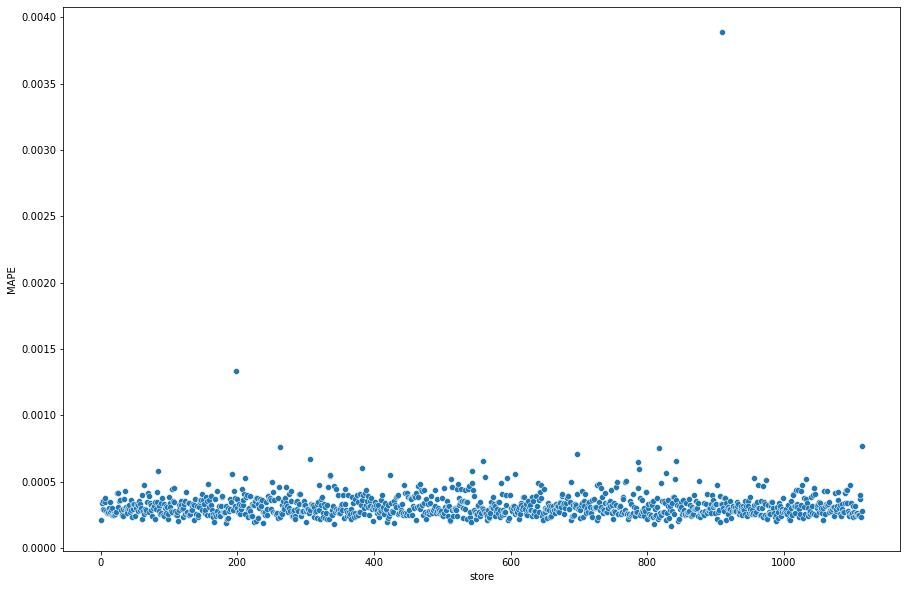

In [199]:
sns.scatterplot(x='store',y='MAPE',data= df92)

In [200]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
278,279,364440.34375,364435.581200,364445.106300,4.762550,0.000425
442,443,191728.18750,191726.872433,191729.502567,1.315067,0.000264
1034,1035,175303.84375,175302.502953,175305.184547,1.340797,0.000298
400,401,272074.31250,272071.666154,272076.958846,2.646346,0.000344


## Total Performance

In [219]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x:np.sum(x),axis= 0).reset_index().rename(columns = {'index':'Scenarios',0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$289,566,560.00"
1,worst_scenario,"R$289,563,760.26"
2,best_scenario,"R$289,569,354.47"


## Machine Learning Performance

In [211]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

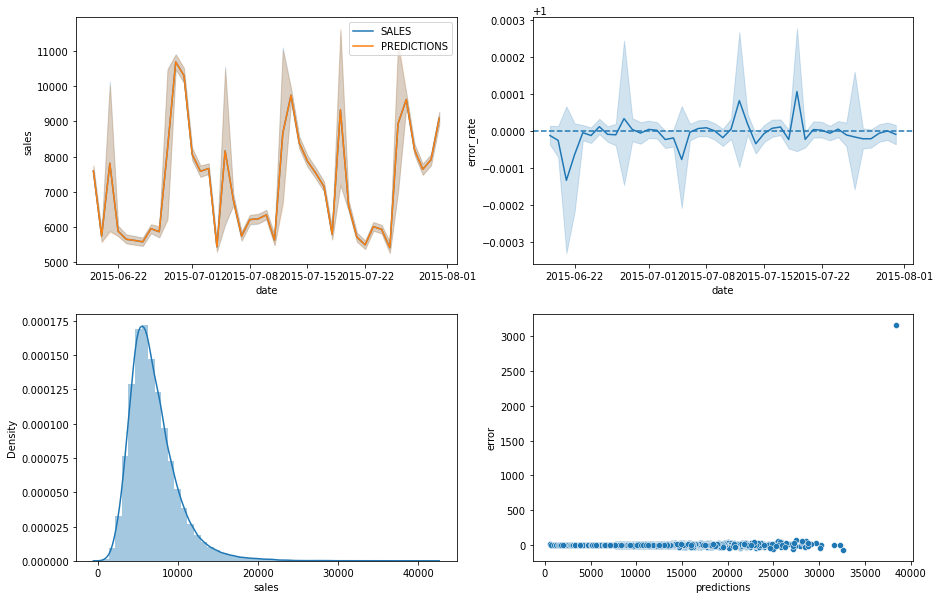

In [220]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data =df9, label='SALES')
sns.lineplot(x='date', y='predictions', data =df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle = '--')


plt.subplot(2,2,3)
sns.distplot(df9['sales'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'])


# Deploying model to production

In [227]:
import pickle

In [234]:
pickle.dump(model_xgb_tuned, open('/Users/Windows/Google Drive/DS em produccao/model/model_rossmann.pkl','wb'))

## Rossman Class

In [267]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime as dt

class Rossman(object):
    def __init__(self):
        self.home_path = 'C:/Users/Windows/Google Drive/DS em produccao/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl','rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl','rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl','rb'))
    def data_cleaining(self, df1): 

        ### Renaming columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new


        ### Data types

        df1['date']= pd.to_datetime(df1['date'])

        #competition_distance              
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)

        #competition_open_since_month    
        df1['competition_open_since_month']= df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis =1)

        #competition_open_since_year     
        df1['competition_open_since_year']= df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis =1)                       

        #promo2_since_week               
        df1['promo2_since_week']= df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis =1)                       

        #promo2_since_year               
        df1['promo2_since_year']= df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis =1)                       

        #promo_interval                  
        month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec',}

        df1['promo_interval'].fillna(0,inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo']= df1[['promo_interval', 'month_map']].apply(lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 )


        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week']=df1['promo2_since_week'].astype(int)
        df1['promo2_since_year']=df1['promo2_since_year'].astype(int)

        return df1 
    
    def feature_engineering(self,df2):
        # year
        df1['year'] = df1['date'].dt.year
        # month
        df1['month'] = df1['date'].dt.month
        # day
        df1['day'] = df1['date'].dt.day
        # week of the year
        df1['week_of_year'] = df1['date'].dt.weekofyear
        # year week
        df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

        # competition since 
        df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
        df1['competition_time_month'] = ((df1['date']-df1['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
        df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days= 7))
        df1['promo_time_week'] = ((df1['date']-df1['promo_since'])/7).apply(lambda x: x.days).astype(int)
        # assortment
        df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended')
        # state holiday
        df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'eastern_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

        ## Row filtering


        df2 = df2[df2['open'] != 0]

        ## Column Selection

        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis = 1)

        return df2

    def data_preparation(self,df5):

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)


        # state_holiday - one hot encoding
        df5 = pd.get_dummies(df5, prefix = 'state_holiday', columns = ['state_holiday'])

        # store_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'])
        

        # assortment - ordinal encoding 
        assortment_dict = {'basic':1,'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x*2.*np.pi/7))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x*2.*np.pi/7))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x*2.*np.pi/12))
        df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x*2.*np.pi/12))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x : np.sin(x*2.*np.pi/30))
        df5['day_cos'] = df5['day'].apply(lambda x : np.cos(x*2.*np.pi/30))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x*2.*np.pi/52))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x*2.*np.pi/52))
 
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
         'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'month_sin',  'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        # join pred into the original data 
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format = 'iso')

## API Handler 

In [268]:
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
import pickle 
import pandas as pd

#loading model

model = pickle.load(open('C:/Users/Windows/Google Drive/DS em produccao/model/model_rossmann.pkl','rb'))
#initialize API 
app = Flask(__name__)

@app.route('/rossman/predict', methods=['POST'])
def rossmann_predict(): 
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index =[0])
        else: # Multiple examples
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        # creatin Rossmann instance
        pipeline = Rossmann()
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # feature engineering 
        df2 = pipeline.feature_engineering(df1)
        # data preparation
        df3 = pipeline.data_preparation(df2)
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)     
        return df_response
        
        
    else: 
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__': 
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rosmmann'

## API Tester

In [304]:
import json
import requests

In [305]:
df10 = pd.read_csv('test.csv')

In [315]:
#merge test dataset + store 
df_test = pd. merge(df10, df_store_raw, how='left', on= 'Store')

# choosing store for prediction
df_test = df_test[df_test['Store'].isin([22,23,65]) ]

# remove closed days
df_test = df_test[df_test['Open'] !=0 ]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [316]:
# convert Dataframe to json
import json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [317]:
# API Call
url = "http://127.0.0.1:5000/rossmann/predict"
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code ))

Status Code 404


In [318]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)